In [1]:
from scipy.interpolate import interp1d
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.5)
sns.set_palette(sns.color_palette("Paired"))
import numpy as np

from pyCode.component import Component
from pyCode.boltzSolver import BoltzSolution
from pyCode.AuxDecays import DecayList, Decay
from pyCode.AuxFuncs import Hfunc, getTemperature, getPressure


INFO:pyCode.AuxFuncs:Loading aux functions. Ignoring BSM corrections to g* and g*_S


In [2]:
f = open('gFunctions.pcl','rb')
gSTAR = pickle.load(f)
gSTARS = pickle.load(f)
Tfunc = pickle.load(f)
f.close()

In [3]:
decays = DecayList()
decayToDM = Decay(instate='Mediator',fstates=['DM','radiation'],br=1.)
decays.addDecay(decayToDM)
decays.Xfraction = 0.1
decays.width = 2.5e-15*(2.6e-7/4.3e-7)**2



#Get the model parameters (or define them here):
TRH = 1e4
TF = 1
    
def nEQbottom(T):
    Zeta3 = 1.20206
    return 3*2*(3./4.)*Zeta3*T**3/np.pi**2

def nEQgluon(T):
    Zeta3 = 1.20206
    return 8*2*Zeta3*T**3/np.pi**2

#Annihilation rate for mediator
data = np.genfromtxt('./width_and_medxs.dat',skip_header=5)
dataR = np.genfromtxt('./sigmav_conversion_bchi-sbotg_500_510_1.dat',skip_header=6,usecols=(0,4))
conv = 0.8579e17

sLog = lambda x: interp1d(data[:,0],np.log(data[:,1]*conv),
                    fill_value='extrapolate',bounds_error=False)(x)
cRateLog = lambda x: interp1d(dataR[:,0],np.log(dataR[:,1]*conv*(2.6e-7)**2),
                    fill_value='extrapolate',bounds_error=False)(x)

#Conversion rates for DM and mediator: 
dofDM = -2 #Number of DM degrees of freedom (Majorana fermion)
dofMed = 3 #Number of Mediator degrees of freedom (complex colored scalar)

@np.vectorize
def sigmaVJan(T):
    x = 500./T
    if x > data[:,0].max():
        return 0.
    sF = sLog(x)
    return np.exp(sF)

@np.vectorize
def cRateDMJan(T):
    x = 500./T
    if x > dataR[:,0].max():
        return 0.
    sF = cRateLog(x)
    return nEQbottom(T)*np.exp(sF)

@np.vectorize
def cRateMedJan(T):
    x = 510./T
    if x > dataR[:,0].max():
        return 0.
    sF = cRateLog(x)
    return nEQgluon(T)*np.exp(sF)*abs(dofMed/dofDM)

In [4]:
#Define the components to be evolved and their properties:    
dm = Component(label='DM',Type='thermal',dof=dofDM,
               mass=500.,
               coSigmav=lambda T,other: 1e-12*sigmaVJan(T)
                ,convertionRate=lambda T,other: cRateDMJan(T)
               )
mediator = Component(label='Mediator',Type='thermal',dof=dofMed,
               mass=510.,decays=decays,
               sigmav=sigmaVJan
                ,convertionRate=lambda T,other: cRateMedJan(T)
               )
compList = [dm,mediator]

In [5]:
skiplines = 10
d = np.genfromtxt('testNewC.dat',names=True,skip_header=skiplines)
n = np.array([d['n_DM'],d['n_Mediator']])
rho = np.array([d['rho_DM'],d['rho_Mediator']])
S = d['S']
T = d['T']
x = d['x']
R = d['R']
nComp = 2

In [6]:
isActive = [True,True]
labelsDict = dict([[comp.label,i] for i,comp in enumerate(compList)])

In [ ]:
eqTerms = {'dNi/dx' : [], 'n' : [], r'$\rho$' : [], 
           'Annihilation' : [],
          'Co-Annihilation' : [],
          'Annihilation Conversion' : [],
          'Scattering Conversion' : [],
          'Decay' : [],
          'Inverse Decay' : [],
          'Injection' : [],
          'Expansion': []}

xdict = {'m/T' : []}

Tfo = 18.6

for iT,Tv in enumerate(T):
    if 500./Tv < 5. or 500./Tv > 20.:
        continue

    
    #Ni = log(n_i/s_0)
    Ni = np.log(n[:nComp,iT])
    #R = rho_i/n_i
    Ri = rho[:nComp,iT]/n[:nComp,iT]
    #NS = log(S/S_0)
    NS = np.log(S[iT])
    
    
    #Compute equilibrium densities:
    dmNeq = np.array([dm.nEQ(Tv) for Tv in T])
    medNeq = np.array([dm.nEQ(Tv) for Tv in T])
    neq = np.array([comp.nEQ(Tv) for comp in compList])
    #Compute ratio of equilibrium densities
    #(helps with numerical instabilities)
    #rNeq[i,j] = neq[i]/neq[j]
    rNeq = np.array([[compi.rNeq(Tv,compj) for compj in compList] for compi in compList])

    H = Hfunc(Tv,rho[:nComp,iT],isActive)
    #Effective equilibrium densities and BRs:
    #NXth[i] = N^{th}_i:
    NXth = np.array([comp.getNXTh(Tv,n[:nComp,iT],rNeq,labelsDict) for comp in compList])
    #NXYth[i,j] = N^{th}_{ij}:
    NXYth = np.array([[compi.getNXYTh(Tv,n[:nComp,iT],rNeq,labelsDict,compj) for compj in compList] 
                      for compi in compList])
    #Effective branching ratio (Beff[i,j] = B^{eff}_{ij}:
    Beff = np.array([[compi.getTotalBRTo(Tv,compj) for compj in compList] for compi in compList])

    dNS = 0.
    for j,comp in enumerate(compList):
        if not isActive[j]: continue
        dNS += comp.getBRX(Tv)*comp.width(Tv)*comp.mass(Tv)*(n[j,iT]-NXth[j])*np.exp(3.*x[iT] - NS)/(H*Tv)
    if np.isinf(dNS):
        print("Infinity found in dNS at T=%1.2g. Will be replaced by a large number" %(T))
        dNS = np.nan_to_num(dNS)

        
    dN = np.zeros(nComp)
    widths = np.array([comp.width(Tv) for comp in compList])
    masses = np.array([comp.mass(Tv) for comp in compList])
    #Expansion term:
    RHS = -3*n[:nComp,iT]
    eqTerms['Expansion'].append(-3*n[:nComp,iT])
    #Decay term:
    if Tv < Tfo:
        RHS += -widths*masses*n[:nComp,iT]/(H*Ri)
    eqTerms['Decay'].append(-widths*masses*n[:nComp,iT]/(H*Ri))
    #Inverse decay term:
    if Tv < Tfo:
        RHS += widths*masses*NXth/(H*Ri) #NXth should be finite if i -> j +..
    eqTerms['Inverse Decay'].append(widths*masses*NXth/(H*Ri))
    #Annihilation term:
    sigmaV = np.array([comp.getSIGV(Tv) for comp in compList])
    if Tv < Tfo:
        RHS += sigmaV*(neq - n[:nComp,iT])*(neq + n[:nComp,iT])/H
    eqTerms['Annihilation'].append(sigmaV*(neq - n[:nComp,iT])*(neq + n[:nComp,iT])/H)
    #Contributions from other BSM states:
    sigvIJ = np.zeros(nComp)
    sigvJJ = np.zeros(nComp)
    cRATE = np.zeros(nComp)
    inj = np.zeros(nComp)
    for i,compi in enumerate(compList):
        for j,compj in enumerate(compList):
            # i + j <-> SM + SM:
            sigVij = compi.getCOSIGV(Tv,compj)
            if sigVij:
                if Tv < Tfo:
                    RHS[i] += (neq[i]*neq[j]-n[i,iT]*n[j,iT])*sigVij/H #Co-annihilation
                sigvIJ[i] += (neq[i]*neq[j]-n[i,iT]*n[j,iT])*sigVij/H
            # i+i <-> j+j:
            sigVjj = comp.getSIGVBSM(Tv,compj)
            if sigVjj:
                if Tv < Tfo:
                    RHS[i] += (rNeq[i,j]*n[j,iT]-n[i,iT])*(rNeq[i,j]*n[j,iT]+n[i,iT])*sigVjj/H #sigVjj*rNeq[i,j]**2 should be finite
                sigvJJ[i] += (rNeq[i,j]*n[j,iT]-n[i,iT])*(rNeq[i,j]*n[j,iT]+n[i,iT])*sigVjj/H
            # i+SM <-> j+SM:
            cRate = comp.getConvertionRate(Tv,compj)
            if cRate:
                if Tv < Tfo:
                    RHS[i] += (rNeq[i,j]*n[j,iT]-n[i,iT])*cRate/H #cRate*rNeq[i,j] should be finite
                cRATE[i] += (rNeq[i,j]*n[j,iT]-n[i,iT])*cRate/H
            # j <-> i +SM:
            if Tv < Tfo:
                RHS[i] += Beff[j,i]*masses[j]*widths[j]*(n[j,iT]-NXYth[j,i])/(H*Ri[j]) #NXYth[j,i] should be finite if j -> i +...
            inj[i] += Beff[j,i]*masses[j]*widths[j]*(n[j,iT]-NXYth[j,i])/(H*Ri[j])
        if not isActive[i]:
            if RHS[i] < 0.:
                continue
            else:
                print("Inactive component %s is being injected" %compi.label)
        elif RHS[i]:
            dN[i] = np.float64(RHS[i])/np.float64(n[i,iT])
            if np.isinf(dN[i]):
                print("Infinity found at in dN[%s] at T=%1.2g. Will be replaced by a large number" %(comp.label,T))
                dN[i] = np.nan_to_num(dN[i])
                
                
#     RHS = np.zeros(nComp)
#     dR = np.zeros(nComp)
#     #Derivatives for the rho/n variables (only for thermal components):
#     for i,comp in enumerate(compList):
#         if not isActive[i] or comp.Type == 'CO':
#             continue
#         mass = masses[i]
#         RHS[i] = -3.*getPressure(mass,rho[i,iT],n[i,iT])  #Cooling term
#         for j, compj in enumerate(compList):
#             if not isActive[j]: continue
#             if j == i: continue
#             massj = masses[j]
#             widthj = widths[j]
#             #Injection and inverse injection terms:
#             RHS[i] += widthj*Beff[j,i]*massj*(1./2. - Ri[i]/Ri[j])*(n[j,iT] - NXYth[j,i])/H #NXth[j,i] should finite if j -> i+..

#         if RHS[i]:
#             dR[i] = np.float64(RHS[i])/np.float64(n[i,iT])
#             if np.isinf(dR[i]):
#                 logger.warning("Infinity found in dR[%s] at T=%1.2g. Will be replaced by a large number" %(comp.label,T))
#                 dR[i] = np.nan_to_num(dR[i])
                
    xdict['m/T'].append(500./Tv)
    eqTerms['n'].append(n[:nComp,iT])
    eqTerms[r'$\rho$'].append(rho[:nComp,iT])
    eqTerms['dNi/dx'].append(RHS)
    
    eqTerms['Co-Annihilation'].append(sigvIJ)
    eqTerms['Annihilation Conversion'].append(sigvJJ)
    eqTerms['Scattering Conversion'].append(cRATE)
    eqTerms['Injection'].append(inj)
    
#     break

In [ ]:
for key in eqTerms:
    eqTerms[key] = np.array(eqTerms[key]).transpose()
for key in xdict:
    xdict[key] = np.array(xdict[key])

In [ ]:
rowLabels = [comp.label for comp in compList]
curveLabels = list(eqTerms.keys())
nrows = len(rowLabels)

plt.figure(figsize=(10,20))

xvals = xdict['m/T']
xlabel = 'm/T'
isub = 0
yLog = True
xLog = False
for irow in range(nrows):
    isub += 1
    plt.subplot(nrows,1,isub)    
    for curve in curveLabels:
        if curve == 'n' or curve == r'$\rho$':continue
        if not np.count_nonzero(eqTerms[curve][irow,:]):
            continue
        if yLog:
            plt.plot(xvals,np.abs(eqTerms[curve][irow,:]),linewidth=2,label='|'+curve+'|')
        else:
            plt.plot(xvals,eqTerms[curve][irow,:],linewidth=2,label=curve)
    plt.title(rowLabels[isub-1])
    plt.xlabel(xlabel)
    plt.ylabel("Eq Terms")
    
#     plt.ylim(-2,2)
    if yLog:
        plt.yscale('log')
    if xLog:
        plt.xscale('log')
    plt.legend()
    
# plt.tight_layout()
plt.show()

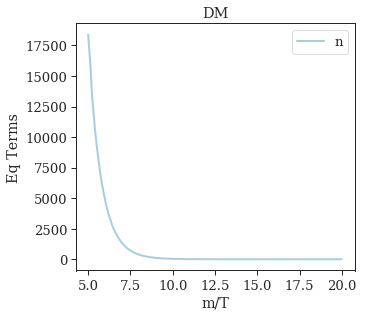

In [10]:
rowLabels = [comp.label for comp in compList]
curveLabels = list(eqTerms.keys())
nrows = len(rowLabels)

plt.figure(figsize=(5,10))

xvals = xdict['m/T']
xlabel = 'm/T'
isub = 0
yLog = False
xLog = False
for irow in range(nrows)[1:]:
    isub += 1
    plt.subplot(nrows,1,isub)    
    for curve in curveLabels:
        if curve != 'n' and curve != r'$\rho$':continue
        if curve != 'n': continue
        if not np.count_nonzero(eqTerms[curve][irow,:]):
            continue
        if yLog:
            plt.plot(xvals,np.abs(eqTerms[curve][irow,:]),linewidth=2,label='|'+curve+'|')
        else:
            plt.plot(xvals,eqTerms[curve][irow,:],linewidth=2,label=curve)
    plt.title(rowLabels[isub-1])
    plt.xlabel(xlabel)
    plt.ylabel("Eq Terms")
    
#     plt.ylim(1e3,1e4)
    if yLog:
        plt.yscale('log')
    if xLog:
        plt.xscale('log')
    plt.legend()
    
# plt.tight_layout()
plt.show()

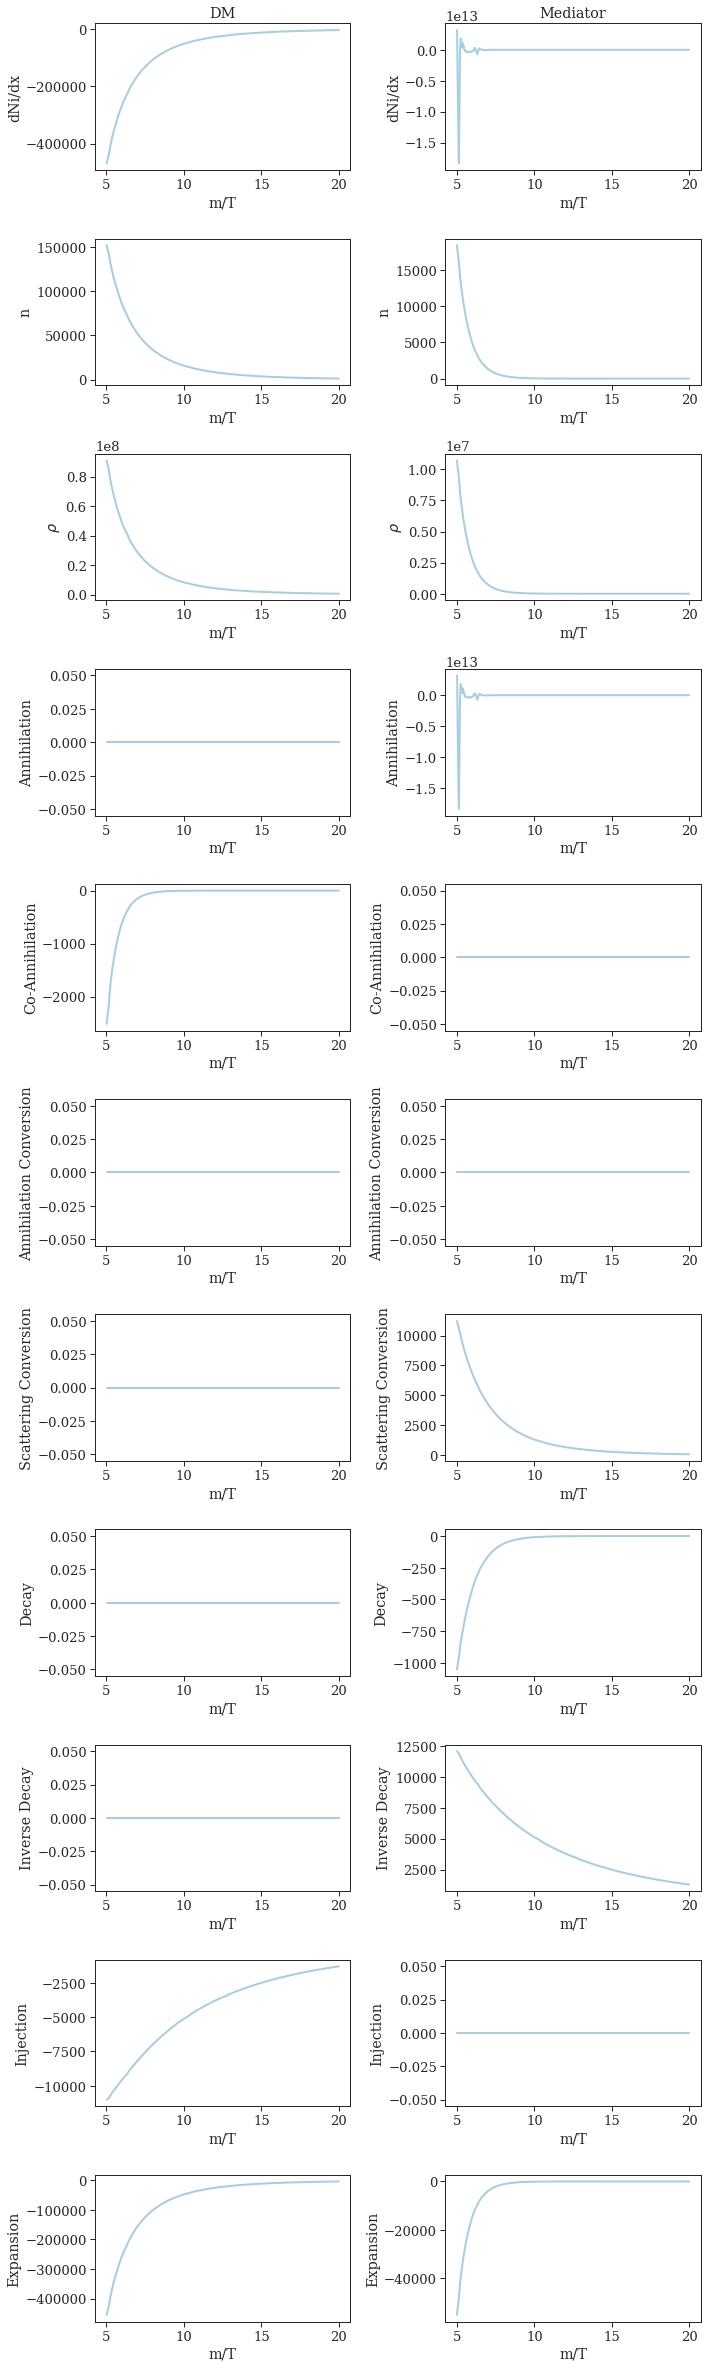

In [11]:
colLabels = [comp.label for comp in compList]
rowLabels = list(eqTerms.keys())
ncols = len(colLabels)
nrows = len(eqTerms)

plt.figure(figsize=(10,3*nrows))

xvals = xdict['m/T']
xlabel = 'm/T'
isub = 0
for irow in range(nrows):
    for icol in range(ncols):
        isub += 1
        plt.subplot(nrows,ncols,isub)
        plt.plot(xvals,eqTerms[rowLabels[irow]][icol,:],linewidth=2)
        plt.xlabel(xlabel)
        plt.ylabel(rowLabels[irow])
        if isub <= ncols:
            plt.title(colLabels[isub-1])
            

plt.tight_layout()
plt.show()

In [12]:
x = np.array([-10,10.,-8,7,-4])

In [13]:
np.abs(x)

array([10., 10.,  8.,  7.,  4.])

In [14]:
x = np.array([])
if not len(x): print('bla')

bla


In [15]:
x = np.array([1,2,3])
y = np.array([4,5,6,7,8,9])
np.hstack((x,y))

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [16]:
x[-1:]

array([3])

In [17]:
np.zeros(3)

array([0., 0., 0.])

In [18]:
1. - np.array([0.,0.5,2.])

array([ 1. ,  0.5, -1. ])

In [19]:
int(3/2)

1

In [20]:
np.mod(557,2)

1

In [21]:
int(False)

0